# Week 3: Autoencoders and Variational autoencoders

### Carl Herrmann

## 1 - Motivation

Imagine that we have a large, high-dimensional dataset. For example, imagine we have a dataset consisting of thousands of images. Each image  is made up of hundreds of pixels, so each data point has hundreds of dimensions. The **[manifold hypothesis](https://deepai.org/machine-learning-glossary-and-terms/manifold-hypothesis)** states that real-world high-dimensional data actually consists of low-dimensional data that is embedded in the high-dimensional space. This means that, while the actual data itself might have hundreds of dimensions, the underlying structure of the data can be sufficiently described using only a few dimensions.

This is the motivation behind dimensionality reduction techniques, which try to take high-dimensional data and project it onto a lower-dimensional surface. For humans who visualize most things in 2D (or sometimes 3D), this usually means projecting the data onto a 2D surface. Examples of dimensionality reduction techniques include [principal component analysis (PCA)](https://en.wikipedia.org/wiki/Principal_component_analysis) and [t-SNE](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding).

Neural networks are often used in the **supervised learning** context, where data consists of pairs $(x, y)$ and the network learns a function $f:X \to Y$. This context applies to both regression (where $y$ is a continuous function of $x$) and classification (where $y$ is a discrete label for $x$). However, neural networks have shown considerable power in the **unsupervised learning** context, where data just consists of points $x$. There are no "targets" or "labels" $y$. Instead, the goal is to learn and understand the structure of the data. In the case of dimensionality reduction, the goal is to find a low-dimensional representation of the data.

## 2 - Principal component analysis

One simple linear dimensional reduction technique is Principal Component Analysis (PCA). Let us start with a simple PCA analysis on the MNIST data.


In [1]:
from sklearn.decomposition import PCA
from matplotlib import cm
import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import numpy as np
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200
import torchvision
from torchvision import datasets, transforms

Now load the MNIST images

In [2]:
batch_size = 32

train_dataset = datasets.MNIST('./data',
                               train=True,
                               download=True,
                               transform=transforms.Compose([
                       transforms.ToTensor(),
                   ]))

test_dataset = datasets.MNIST('./data',
                                    train=False,
                               transform=transforms.Compose([
                       transforms.ToTensor(),
                   ]))

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                                batch_size=batch_size,
                                                shuffle=False)

train_images = train_loader.dataset.data.detach().numpy().reshape(-1, 28*28)
print(f'Num training images: {len(train_images)},\tmin val: {train_images.min():.3f},\tmax val: {train_images.max():.3f}')

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 17.1MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 494kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.55MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 9.65MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Num training images: 60000,	min val: 0.000,	max val: 255.000


We learn the first principal components on the training dataset (=60000 digit images) and plot the principal components

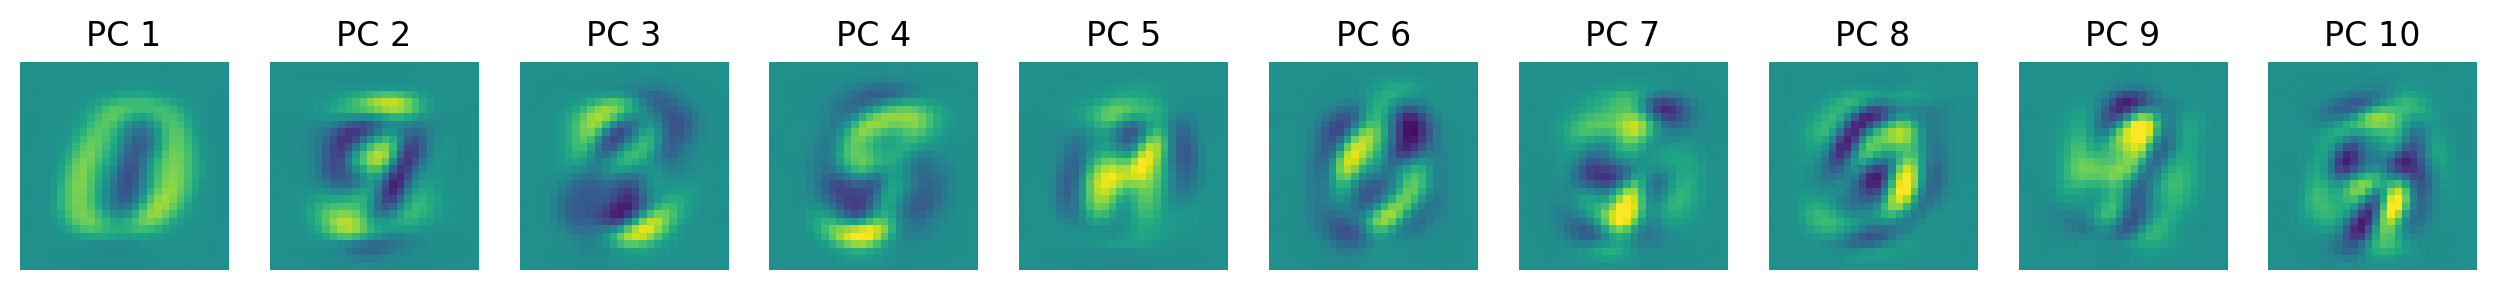

In [3]:
n_components = 10
pca = PCA(n_components=n_components)
pca.fit(train_images)
fig = plt.figure(figsize=(n_components*np.power(n_components, 1/5),3))
axes = []
for i in range(n_components):
    ax_ = fig.add_subplot(1, n_components, i+1)
    ax_.imshow(pca.components_[i].reshape(28,28), interpolation='nearest', clim=(-.15, .15));
    ax_.set_title(f'PC {i+1}')
    ax_.axis('off')

    axes.append(ax_)

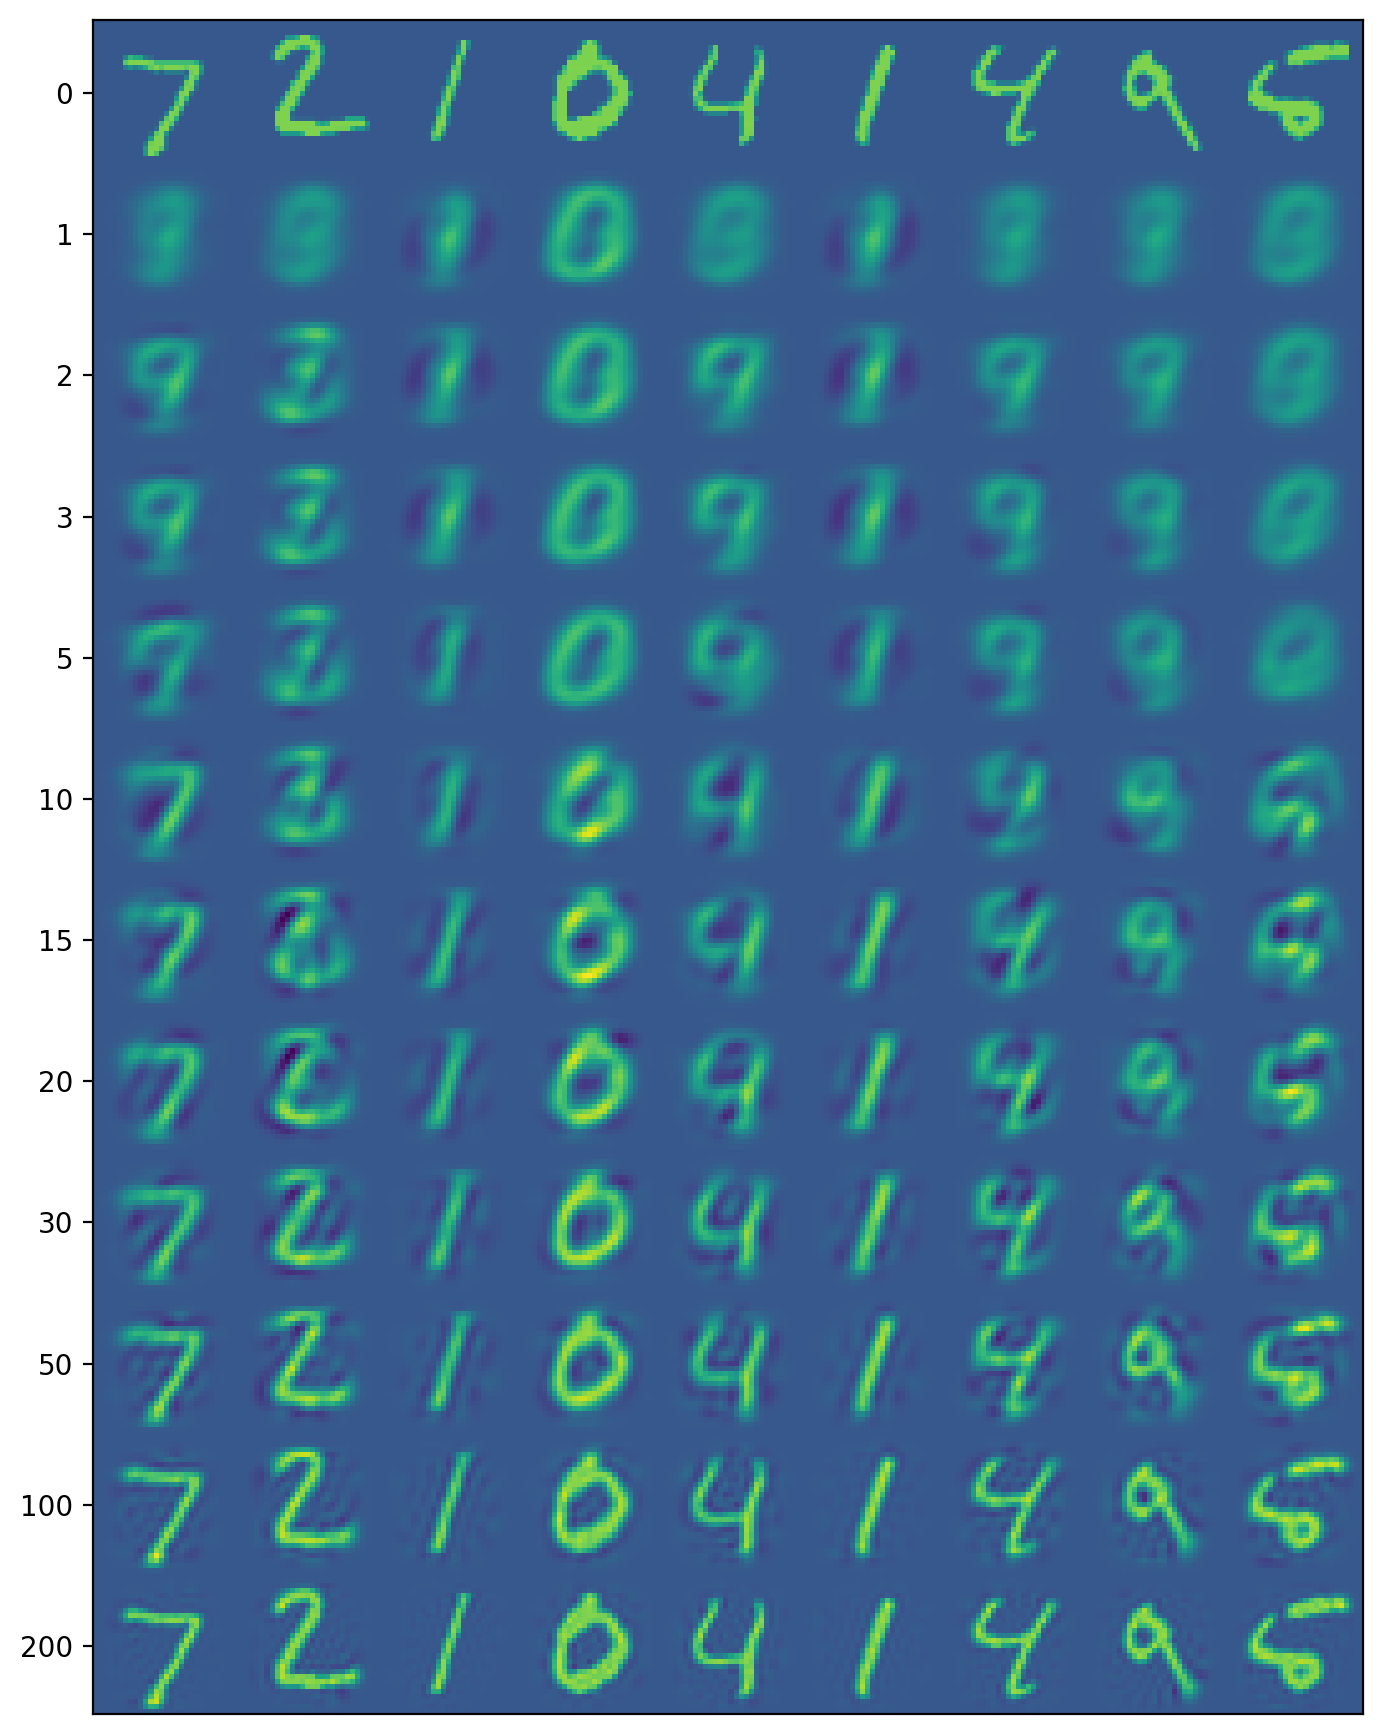

In [4]:
n_pc = [1,2,3,5,10,15,20,30,50,100,200]

# Try PCA on first ten test images
n_images = 9
n_components = len(n_pc)
test_images = np.array(test_loader.dataset.data[:n_images].numpy().reshape((n_images,784)))

# Plot the first ten test images and the corresponding outputs
fig = plt.figure(figsize=(10, n_components))
ax = fig.add_subplot(111)
images_in = [test_images[j].reshape(-1, 28) for j in range(n_images)]
image = np.concatenate(images_in, axis=1)

for i in n_pc:
    pca = PCA(n_components=i)
    pca.fit(train_images)
    test_outputs = pca.inverse_transform(pca.transform(test_images))
    images_out = [test_outputs[j].reshape(-1, 28) for j in range(n_images)]
    image_out = np.concatenate(images_out, axis=1)
    image = np.concatenate([image, image_out])

ax.matshow(image)
ax.set_xticks(np.array([]))
y_lim = ax.get_ylim()
y_scale = (y_lim[0] - y_lim[1])/(n_components+1)
ax.set_yticks(np.linspace(.5, n_components+.5, n_components+1) * y_scale)

a = [0]
a.extend(n_pc)
ax.set_yticklabels(a)
plt.show()

## 3 - Autoencoders

Autoencoders are a special kind of neural network used to perform dimensionality reduction. We can think of autoencoders as being composed of two networks, an **encoder** $f$ and a **decoder** $h$.

The encoder learns a non-linear transformation $f:X \to Z$ that projects the data from the original high-dimensional input space $X$ to a lower-dimensional **latent space** $Z$. We call $z = f(x)$ a **latent vector**. A latent vector is a low-dimensional representation of a data point that contains information about $x$. The transformation $f$ should have certain properties, like similar values of $x$ should have similar latent vectors (and dissimilar values of $x$ should have dissimilar latent vectors).

A decoder learns a non-linear transformation $h: Z \to X$ that projects the latent vectors back into the original high-dimensional input space $X$. This transformation should take the latent vector $z = f(x)$ and reconstruct the original input data $\hat{x} = h(z) = h(f(x))$.

An autoencoder is just the composition of the encoder and the decoder $h(f(x))$. The autoencoder is trained to minimize the difference between the input $x$ and the reconstruction $\hat{x}$ using a kind of **reconstruction loss**. Because the autoencoder is trained as a whole (we say it's trained "end-to-end"), we simultaneosly optimize the encoder and the decoder.

Below is an implementation of an autoencoder written in PyTorch. We apply it to the MNIST dataset.

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [6]:
device

'cuda'

Below we write the `Encoder` class by subclassing `torch.nn.Module`, which lets us define the `__init__` method storing layers as an attribute, and a `forward` method describing the forward pass of the network.

In [7]:
class Encoder(nn.Module):
    def __init__(self, latent_dims,input_dim):
        super(Encoder, self).__init__()
        self.linear1 = nn.Linear(input_dim**2, 512)
        self.linear2 = nn.Linear(512, latent_dims)

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        return self.linear2(x)

We do something similar for the `Decoder` class, ensuring we reshape the output.

In [8]:
class Decoder(nn.Module):
    def __init__(self, latent_dims,input_dim):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(latent_dims, 512)
        self.linear2 = nn.Linear(512, input_dim**2)

    def forward(self, z):
        z = F.relu(self.linear1(z))
        z = torch.sigmoid(self.linear2(z))
        return z.reshape((-1, 1, input_dim, input_dim))

FInally, we write an `Autoencoder` class that combines these two. Note that we could have easily written this entire autoencoder as a single neural network, but splitting them in two makes it conceptually clearer.

In [9]:
class Autoencoder(nn.Module):
    def __init__(self, latent_dims,input_dim):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(latent_dims,input_dim)
        self.decoder = Decoder(latent_dims,input_dim)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

Next, we will write some code to train the autoencoder on the MNIST dataset.

In [10]:
def train(autoencoder, data, epochs=20):
    opt = torch.optim.Adam(autoencoder.parameters())
    losses = []
    for epoch in range(epochs):
        print("epoch: ",epoch)
        loss_e = 0
        for x, y in data:
            x = x.to(device) # GPU
            opt.zero_grad()
            x_hat = autoencoder(x)
            loss = ((x - x_hat)**2).sum()
            loss.backward()
            opt.step()
            loss_e += loss.to('cpu').detach().numpy()
        losses.append(loss_e/len(data))
    return autoencoder, losses

In [11]:
latent_dims = 2
input_dim = 28
autoencoder = Autoencoder(latent_dims,input_dim).to(device) # GPU

data = torch.utils.data.DataLoader(
        torchvision.datasets.MNIST('./data',
               transform=torchvision.transforms.ToTensor(),
               download=True),
        batch_size=128,
        shuffle=True)

autoencoder, losses = train(autoencoder, data,epochs=20)

epoch:  0
epoch:  1
epoch:  2
epoch:  3
epoch:  4
epoch:  5
epoch:  6
epoch:  7
epoch:  8
epoch:  9
epoch:  10
epoch:  11
epoch:  12
epoch:  13
epoch:  14
epoch:  15
epoch:  16
epoch:  17
epoch:  18
epoch:  19


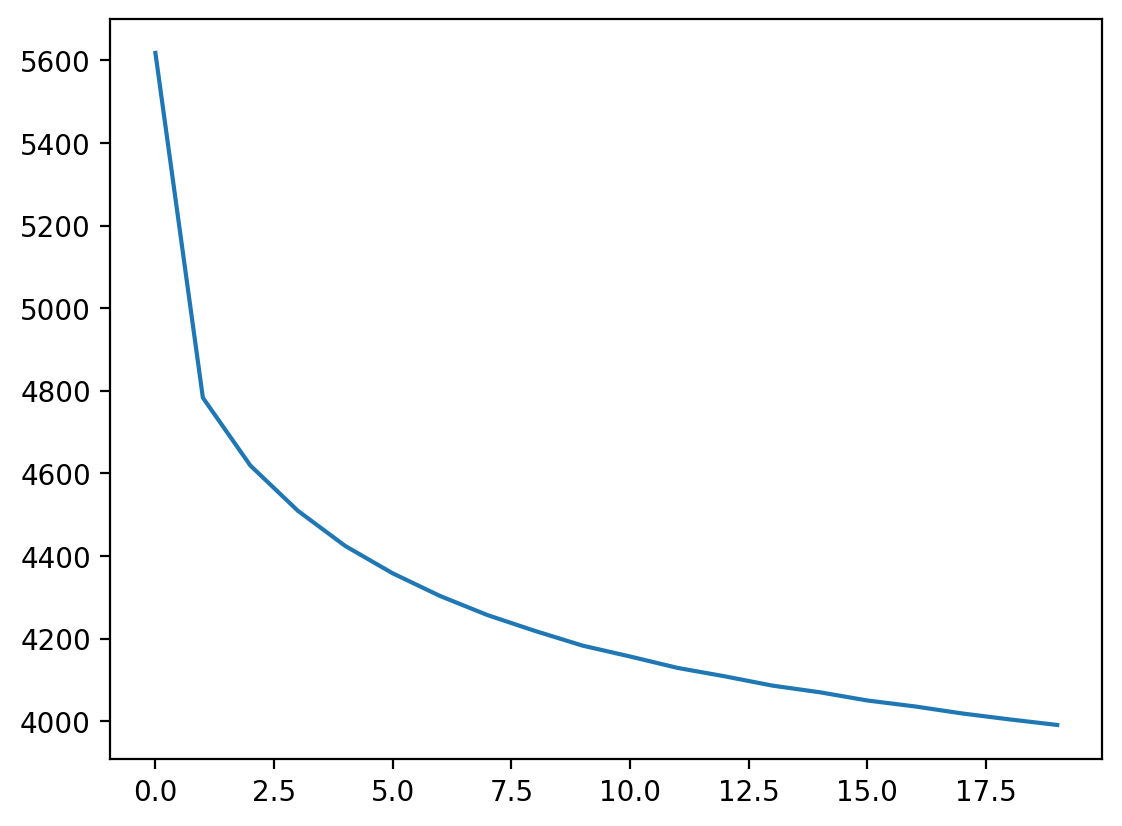

In [12]:
plt.plot(losses)

> **Question 1**: Define a training and validation dataset and plot both loss curves. Compute the validation loss at the end of each epoch. You can reuse the dataloaders from the PCA section! Can you comment on the validation vs training loss? You can check [this website](https://towardsdatascience.com/what-your-validation-loss-is-lower-than-your-training-loss-this-is-why-5e92e0b1747e).

### SOLUTION

In [13]:
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as transforms
import torchvision.datasets as datasets

batch_size = 32

train_dataset = datasets.MNIST('./data',
                               train=True,
                               download=True,
                               transform=transforms.Compose([
                       transforms.ToTensor(),
                   ]))

test_dataset = datasets.MNIST('./data',
                                    train=False,
                               transform=transforms.Compose([
                       transforms.ToTensor(),
                   ]))

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                                batch_size=batch_size,
                                                shuffle=False)

train_images = train_loader.dataset.data.detach().numpy().reshape(-1, 28*28)
print(f'Num training images: {len(train_images)},\tmin val: {train_images.min():.3f},\tmax val: {train_images.max():.3f}')

# Load the MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
mnist_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)

# Split the dataset into training and validation sets
train_size = int(0.8 * len(mnist_dataset))
val_size = len(mnist_dataset) - train_size
train_dataset, val_dataset = random_split(mnist_dataset, [train_size, val_size])

# Create DataLoader objects for training and validation
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)


In [14]:
def train(autoencoder, train_loader, val_loader, epochs=20):
    opt = torch.optim.Adam(autoencoder.parameters())
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        print("Epoch: ", epoch)

        # Training phase
        autoencoder.train()
        train_loss = 0
        for x, _ in train_loader:
            x = x.to(device)  # GPU
            opt.zero_grad()
            x_hat = autoencoder(x)
            loss = ((x - x_hat)**2).sum()
            loss.backward()
            opt.step()
            train_loss += loss.to('cpu').detach().numpy()
        train_losses.append(train_loss / len(train_loader))

        # Validation phase
        autoencoder.eval()
        val_loss = 0
        with torch.no_grad():
            for x, _ in val_loader:
                x = x.to(device)  # GPU
                x_hat = autoencoder(x)
                loss = ((x - x_hat)**2).sum()
                val_loss += loss.to('cpu').detach().numpy()
        val_losses.append(val_loss / len(val_loader))

        print(f"Epoch {epoch}: Train Loss = {train_losses[-1]}, Val Loss = {val_losses[-1]}")

    return autoencoder, train_losses, val_losses

Epoch:  0
Epoch 0: Train Loss = 5827.4067734375, Val Loss = 5109.620054853724
Epoch:  1
Epoch 1: Train Loss = 4963.237248697917, Val Loss = 4802.787628823138
Epoch:  2
Epoch 2: Train Loss = 4736.562229166667, Val Loss = 4646.70301072141
Epoch:  3
Epoch 3: Train Loss = 4605.786431640625, Val Loss = 4528.360071060505
Epoch:  4
Epoch 4: Train Loss = 4503.996734375, Val Loss = 4459.640219830452
Epoch:  5
Epoch 5: Train Loss = 4435.4794244791665, Val Loss = 4395.479505173704
Epoch:  6
Epoch 6: Train Loss = 4379.344477213542, Val Loss = 4360.502862159242
Epoch:  7
Epoch 7: Train Loss = 4335.471381510417, Val Loss = 4315.384383830618
Epoch:  8
Epoch 8: Train Loss = 4296.283290364583, Val Loss = 4280.376625872673
Epoch:  9
Epoch 9: Train Loss = 4264.622693359375, Val Loss = 4278.723837994515
Epoch:  10
Epoch 10: Train Loss = 4237.99419921875, Val Loss = 4245.536210729721
Epoch:  11
Epoch 11: Train Loss = 4209.4143828125, Val Loss = 4227.44287369099
Epoch:  12
Epoch 12: Train Loss = 4183.543479

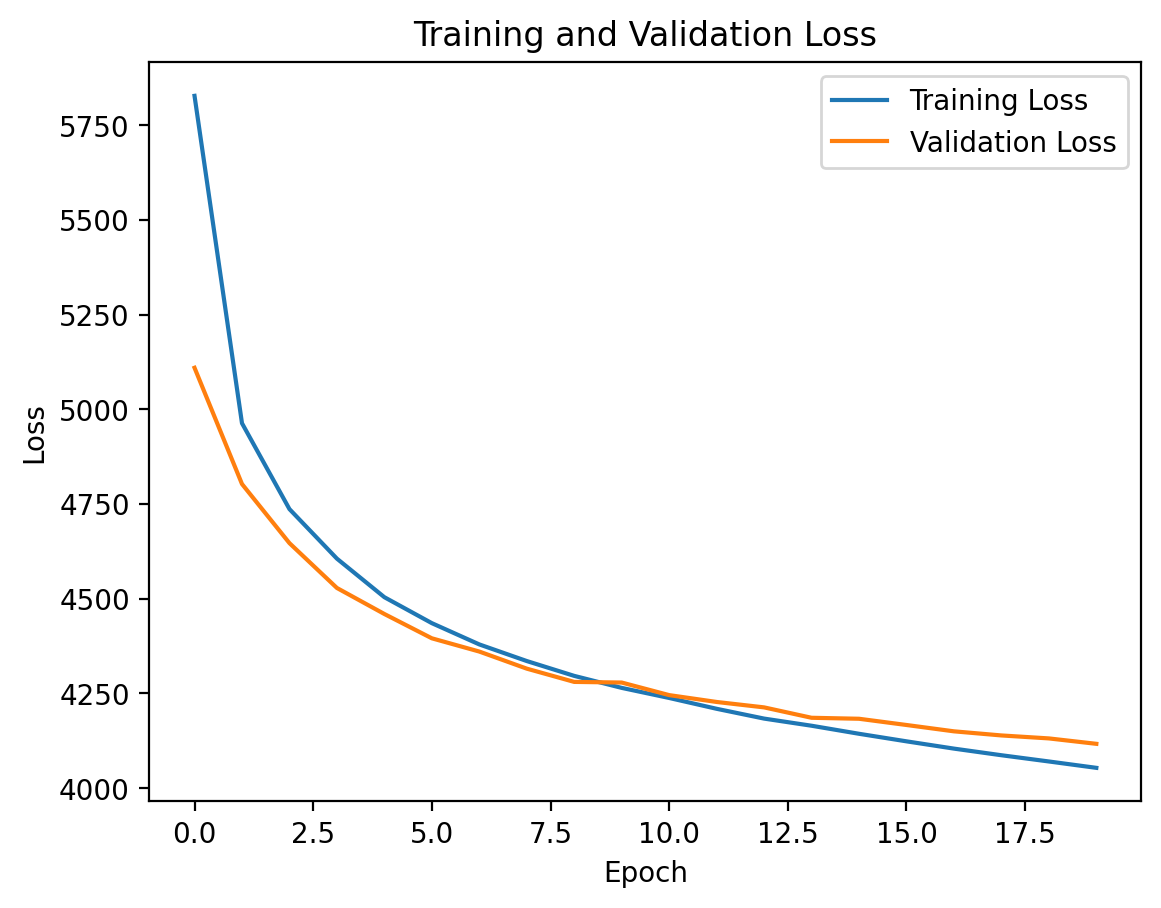

In [15]:
# Initialize the autoencoder
latent_dims = 2
input_dim = 28
autoencoder = Autoencoder(latent_dims, input_dim).to(device)  # GPU

# Train the autoencoder
autoencoder, train_losses, val_losses = train(autoencoder, train_loader, val_loader, epochs=20)

# Plot the training and validation loss curves
import matplotlib.pyplot as plt

plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

***

> **Question 2**: Test an overcomplete, linear AE, and plot training and test loss. Compare it to the losses of the undercomplete version.

### SOLUTION

***

 What should we look at once we've trained an autoencoder?

1. Look at the latent space. If the latent space is 2-dimensional, then we can transform a batch of inputs $x$ using the encoder and make a scatterplot of the output vectors. Since we also have access to labels for MNIST, we can colour code the outputs to see what they look like.
2. Sample the latent space to produce output. If the latent space is 2-dimensional, we can sample latent vectors $z$ from the latent space over a uniform grid and plot the decoded latent vectors on a grid.

In [ ]:
def plot_latent(autoencoder, data, num_batches=100):
    for i, (x, y) in enumerate(data):
        z = autoencoder.encoder(x.to(device))
        z = z.to('cpu').detach().numpy()
        plt.scatter(z[:, 0], z[:, 1], c=y, cmap='tab10',s=1)
        if i > num_batches:
            plt.colorbar()
            break

In [ ]:
plot_latent(autoencoder, data,num_batches=100)

The resulting latent vectors cluster similar digits together. We can also sample uniformly from the latent space and see how the decoder reconstructs inputs from arbitrary latent vectors.

In [ ]:
def plot_reconstructed(autoencoder, r0=(-5, 30), r1=(-20, 15), n=12):
    w = 28
    img = np.zeros((n*w, n*w))
    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            z = torch.Tensor([[x, y]]).to(device)
            x_hat = autoencoder.decoder(z)
            x_hat = x_hat.reshape(28, 28).to('cpu').detach().numpy()
            img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
    plt.imshow(img, extent=[*r0, *r1])

In [ ]:
plot_reconstructed(autoencoder)

We intentionally plot the reconstructed latent vectors using approximately the same range of values taken on by the actual latent vectors. We can see that the reconstructed latent vectors look like digits, and the kind of digit corresponds to the location of the latent vector in the latent space.

You may have noticed that there are "gaps" in the latent space, where data is never mapped to. This becomes a problem when we try to use autoencoders as **generative models**. The goal of generative models is to take a data set $X$ and produce more data points from the same distribution that $X$ is drawn from. For autoencoders, this means sampling latent vectors $z \sim Z$ and then decoding the latent vectors to produce images. If we sample a latent vector from a region in the latent space that was never seen by the decoder during training, the output might not make any sense at all. We see this in the top left corner of the `plot_reconstructed` output, which is empty in the latent space, and the corresponding decoded digit does not match any existing digits.

## 4 - Variational Autoencoders

The only constraint on the latent vector representation for traditional autoencoders is that latent vectors should be easily decodable back into the original image. As a result, the latent space $Z$ can become disjoint and non-continuous. Variational autoencoders try to solve this problem.

In traditional autoencoders, inputs are mapped deterministically to a latent vector $z = f(x)$. In variational autoencoders, inputs are mapped to a probability distribution over latent vectors, and a latent vector is then sampled from that distribution. The decoder becomes more robust at decoding latent vectors as a result.

Specifically, instead of mapping the input $x$ to a latent vector $z = f(x)$, we map it instead to a mean vector $\mu(x)$ and a vector of standard deviations $\sigma(x)$. These parametrize a diagonal Gaussian distribution $\mathcal{N}(\mu, \sigma)$, from which we then sample a latent vector $z \sim \mathcal{N}(\mu, \sigma)$.

This is generally accomplished by replacing the last layer of a traditional autoencoder with two layers, each of which output $\mu(x)$ and $\sigma(x)$. An exponential activation is often added to $\sigma(x)$ to ensure the result is positive.

However, this does not completely solve the problem. There may still be gaps in the latent space because the outputted means may be significantly different and the standard deviations may be small. To reduce that, we add an **auxillary loss** that penalizes the distribution $p(z \mid x)$ for being too far from the standard normal distribution $\mathcal{N}(0, 1)$. This penalty term is the KL divergence between $p(z \mid x)$ and $\mathcal{N}(0, 1)$, which is given by
$$
\mathbb{KL}\left( \mathcal{N}(\mu, \sigma) \parallel \mathcal{N}(0, 1) \right) = \sum_{x \in X} \left( \frac{1}{2}\sigma^2 + \frac{1}{2}\mu^2 - \log \sigma - \frac{1}{2} \right)
$$

This expression applies to two univariate Gaussian distributions. Extending it to our diagonal Gaussian distributions is not difficult; we simply sum the KL divergence for each dimension.

This loss is useful for two reasons. First, we cannot train the encoder network by gradient descent without it, since gradients cannot flow through sampling (which is a non-differentiable operation). Second, by penalizing the KL divergence in this manner, we can encourage the latent vectors to occupy a more centralized and uniform location. In essence, we force the encoder to find latent vectors that approximately follow a standard Gaussian distribution that the decoder can then effectively decode.

To implement this, we do not need to change the `Decoder` class. We only need to change the `Encoder` class to produce $\mu(x)$ and $\sigma(x)$, and then use these to sample a latent vector. We also use this class to keep track of the KL divergence loss term.

In [ ]:
device

'cuda'

In [ ]:
class VariationalEncoder(nn.Module):
    def __init__(self, latent_dims,input_dim):
        super(VariationalEncoder, self).__init__()
        self.linear1 = nn.Linear(input_dim**2, 512)
        self.linear2 = nn.Linear(512, latent_dims)
        self.linear3 = nn.Linear(512, latent_dims)

        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc.to(device)
        self.N.scale = self.N.scale.to(device)
        self.kl = 0

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        sigma = torch.exp(self.linear3(x))
        mu =  self.linear2(x)
        z = mu + sigma*self.N.sample(mu.shape)
        self.kl = (0.5*sigma**2 + 0.5*mu**2 - torch.log(sigma) - 1/2).sum()
        return z

The autoencoder class changes a single line of code, swappig out an `Encoder` for a `VariationalEncoder`.

In [ ]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims,ipnut_dim):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(latent_dims,input_dim)
        self.decoder = Decoder(latent_dims,input_dim)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

In order to train the variational autoencoder, we only need to add the auxillary loss in our training algorithm.

The following code is essentially copy-and-pasted from above, with a single term added added to the loss (`autoencoder.encoder.kl`). We have added a hyperparameter $\lambda$ to weight the KL contribution to the loss!

In [ ]:
def train(autoencoder, data, epochs=20,l=5):
    opt = torch.optim.Adam(autoencoder.parameters())
    losses_recon = np.array([])
    losses_kl = np.array([])
    for epoch in range(epochs):
        print("epoch: ",epoch)
        loss_recon_e=0
        loss_kl_e=0
        for x, y in data:
            x = x.to(device) # GPU
            opt.zero_grad()
            x_hat = autoencoder(x)
            loss_recon = ((x - x_hat)**2).sum()
            loss_kl = autoencoder.encoder.kl
            loss = loss_recon + l*loss_kl
            loss.backward()
            loss_recon_e += loss_recon.to('cpu').detach().numpy()
            loss_kl_e += loss_kl.to('cpu').detach().numpy()
            opt.step()
        losses_recon = np.append(losses_recon,loss_recon_e)
        losses_kl = np.append(losses_kl,loss_kl_e)
    return autoencoder, losses_recon,losses_kl

In [ ]:
data = torch.utils.data.DataLoader(
        torchvision.datasets.MNIST('./data',
               transform=torchvision.transforms.ToTensor(),
               download=True),
        batch_size=128,
        shuffle=True)

In [ ]:
latent_dims = 2
input_dim=28
vae = VariationalAutoencoder(latent_dims,input_dim).to(device) # GPU
vae,loss_recon,loss_kl = train(vae, data,epochs=40,l=1)

epoch:  0
epoch:  1
epoch:  2
epoch:  3
epoch:  4
epoch:  5
epoch:  6
epoch:  7
epoch:  8
epoch:  9
epoch:  10
epoch:  11
epoch:  12
epoch:  13
epoch:  14
epoch:  15
epoch:  16
epoch:  17
epoch:  18
epoch:  19
epoch:  20
epoch:  21
epoch:  22
epoch:  23
epoch:  24
epoch:  25
epoch:  26
epoch:  27
epoch:  28
epoch:  29
epoch:  30
epoch:  31
epoch:  32
epoch:  33
epoch:  34
epoch:  35
epoch:  36
epoch:  37
epoch:  38
epoch:  39


Let's plot the latent vector representations of a few batches of data.

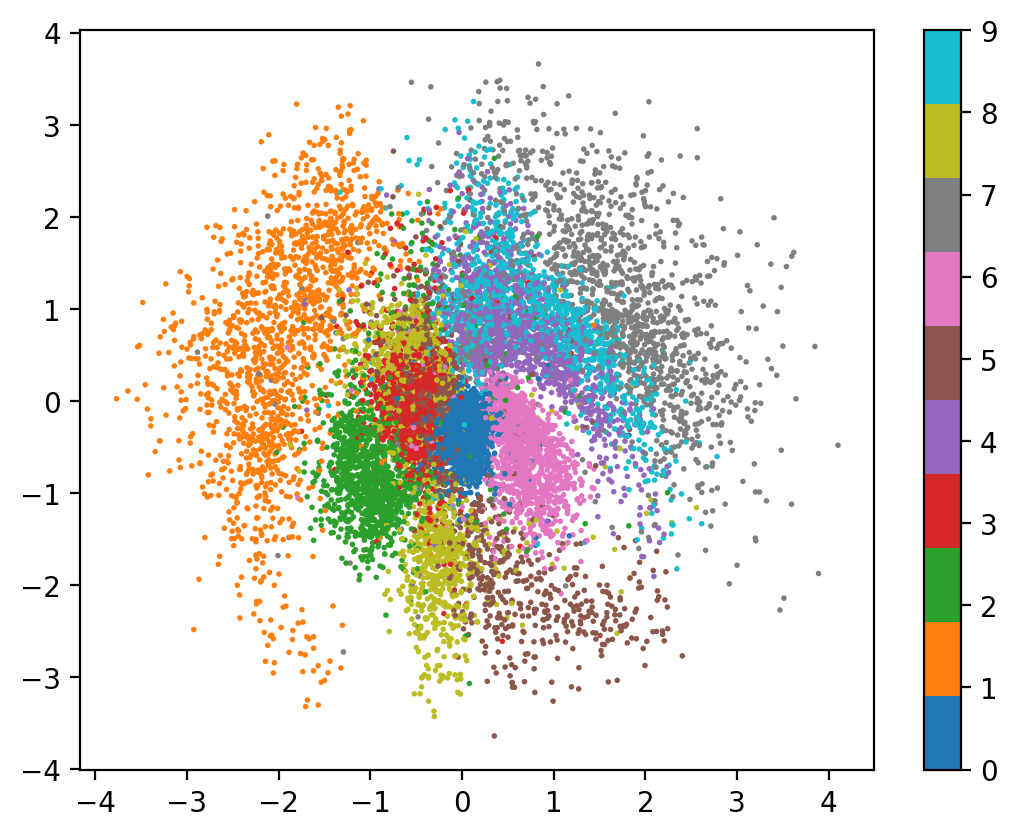

In [ ]:
plot_latent(vae, data)

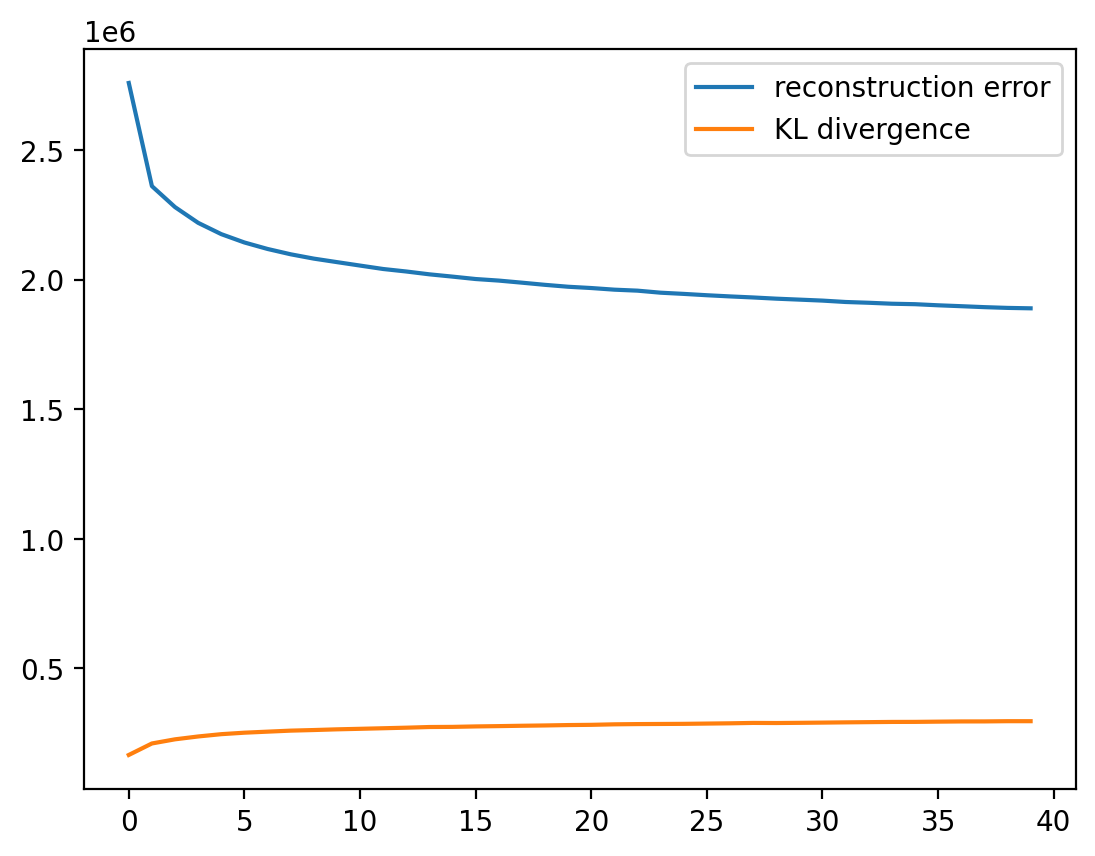

In [ ]:
plt.plot(loss_recon,label='reconstruction error')
plt.plot(loss_kl,label='KL divergence')
plt.legend()
plt.show()

> **Question 3**: try different values of $\lambda$ to see the effect on the latent space!

We can see that, compared to the traditional autoencoder, the range of values for latent vectors is much smaller, and more centralized. The distribution overall of $p(z \mid x)$ appears to be much closer to a Gaussian distribution.

Let's also look at the reconstructed digits from the latent space:

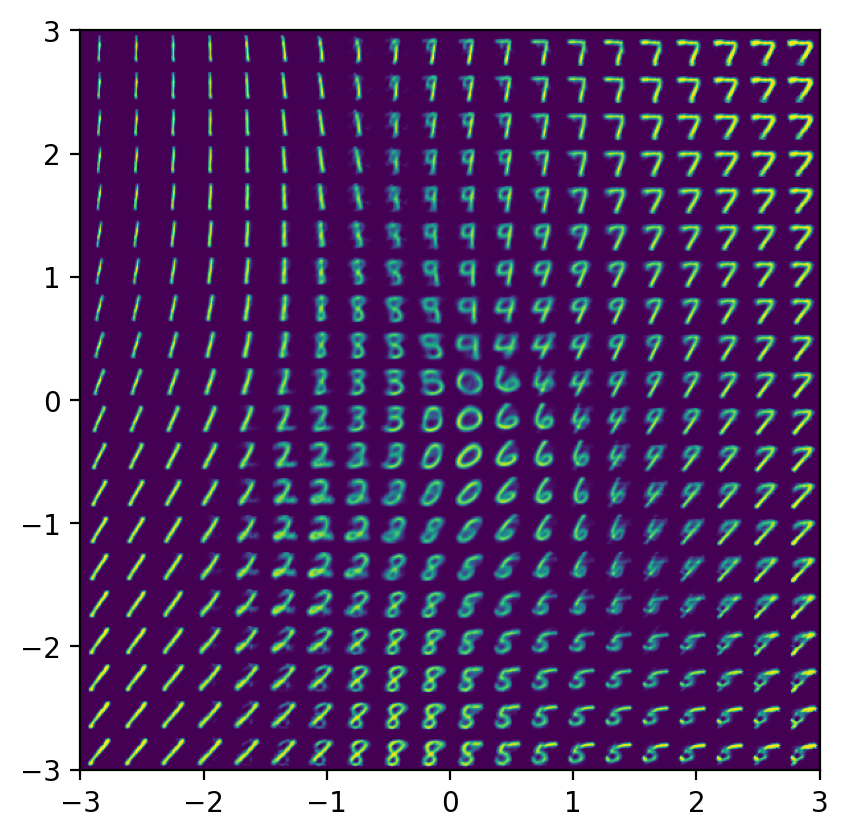

In [ ]:
plot_reconstructed(vae, r0=(-3, 3), r1=(-3, 3),n=20)

# Conclusions

Variational autoencoders produce a latent space $Z$ that is more compact and smooth than that learned by traditional autoencoders. This lets us randomly sample points $z \sim Z$ and produce corresponding reconstructions $\hat{x} = h(z)$ that form realistic digits, unlike traditional autoencoders.

## 5 - Interpolation

One final thing that I wanted to try out was **interpolation**. Given two inputs $x_1$ and $x_2$, and their corresponding latent vectors $z_1$ and $z_2$, we can interpolate between them by decoding latent vectors between $x_1$ and $x_2$.

The following code produces a row of images showing the interpolation between digits.

In [ ]:
def interpolate(autoencoder, x_1, x_2, n=12):
    z_1 = autoencoder.encoder(x_1)
    z_2 = autoencoder.encoder(x_2)
    z = torch.stack([z_1 + (z_2 - z_1)*t for t in np.linspace(0, 1, n)])
    interpolate_list = autoencoder.decoder(z)
    interpolate_list = interpolate_list.to('cpu').detach().numpy()

    w = 28
    img = np.zeros((w, n*w))
    for i, x_hat in enumerate(interpolate_list):
        img[:, i*w:(i+1)*w] = x_hat.reshape(28, 28)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])

In [ ]:
x, y = next(data.__iter__()) # hack to grab a batch
x_1 = x[y == 1][1].to(device) # find a 1
x_2 = x[y == 0][1].to(device) # find a 0

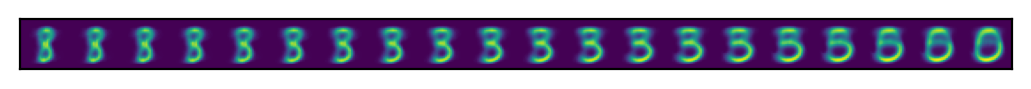

In [ ]:
interpolate(vae, x_1, x_2, n=20)

In [ ]:
interpolate(autoencoder, x_1, x_2, n=20)

## 6 - Exercises

Try to implement a **denoising autoencoder**; you can use the function below to generate noisy input samples with a gaussian noise.

1. modifiy the function to allow adding salt 'n pepper noise to the images
2. implement a DAE; you can use different numbers of layers / activation functions / dimension of latent space
3. Make a plot with the original image, the noised image and the reconstructed image for several examples of input images.
4. compare different types (gaussian / salt n pepper) and levels of noise on the performance of the DAE
5. compare different DAE architectures regarding the denoising performances.


We start by noising the training and testing images with gaussian noise

In [ ]:
train_images = train_loader.dataset.data.detach().numpy()
test_images = test_loader.dataset.data.detach().numpy()

In [ ]:
def add_gaussian_noise(img,mean=10,var=30):
    import math
    img=img.astype(np.float32)

    sigma=var**.5
    noise=np.random.normal(mean,sigma,img.shape)
    img=img+noise
    return img



In [ ]:
noised_train = np.zeros((len(train_images),28,28),dtype='float32')
for i in range(len(train_images)):
  noised_train[i]=add_gaussian_noise(train_images[i]).reshape(28,28)
  noised_train[i] = np.float32(noised_train[i])

noised_test = np.zeros((len(test_images),28,28),dtype='float32')
for i in range(len(test_images)):
  noised_test[i]=add_gaussian_noise(test_images[i]).reshape(28,28)
  noised_test[i] = np.float32(noised_test[i])

This class generates a Dataset object from the original and noised images:

In [ ]:
class noisedDataset():

  def __init__(self,datasetnoised,datasetclean,transform):
    self.noise=datasetnoised
    self.clean=datasetclean
    #self.labels=labels
    self.transform=transform

  def __len__(self):
    return len(self.noise)

  def __getitem__(self,idx):
    xNoise=self.noise[idx]
    xClean=self.clean[idx]
    #y=self.labels[idx]

    if self.transform != None:
      xNoise=self.transform(xNoise)
      xClean=self.transform(xClean)


    return (xNoise,xClean)


tsfms=transforms.Compose([
    transforms.ToTensor()
])

data = noisedDataset(noised_train,train_images,tsfms)

In [ ]:
data

### SOLUTION